# Autoencoder Model: Carpet dataset

## Extract the data

In [1]:
import os
import tarfile

# Nombre de la carpeta y del archivo tar
folder_name = "carpet"
tar_path = "carpet.tar"

# Solo extraer si la carpeta no existe
if not os.path.exists(folder_name):
    with tarfile.open(tar_path) as f:
        f.extractall(".")

## Visualize some examples

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

image_path = "carpet/test/hole/000.png"
image = Image.open(image_path)
print(image.size)

(1024, 1024)


torch.Size([3, 224, 224])


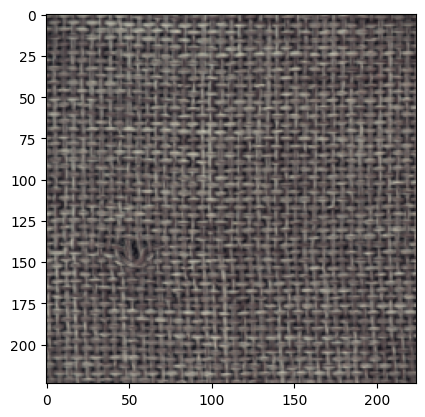

In [3]:
from torchvision.transforms import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor() # Convert the image to a PyTorch tensor and divide by 255.0
])

image = transform(image)
print(image.shape)

plt.imshow(image.permute(1, 2, 0))
plt.show()

### Memory consumed by the tensor

In [4]:
memory_usage = image.numel() * image.element_size()
print(f"Memory usage of the tensor: {memory_usage * 279//1024} KB") # 279 is the number of samples we have

Memory usage of the tensor: 164052 KB


In [5]:
from torchvision.datasets import ImageFolder

train_image_path = "carpet/train"

good_dataset = ImageFolder(root=train_image_path, transform=transform)

x, y = good_dataset[0]

print("Image Shape:", x.shape)
print("Label:", y)

Image Shape: torch.Size([3, 224, 224])
Label: 0


### Train test split for the autoencoder

In [6]:
import torch

train_dataset, test_dataset = torch.utils.data.random_split(good_dataset, [0.8, 0.2])

print("Total number of samples in the original dataset:", len(good_dataset))
print("Number of samples in the training subset:", len(train_dataset))
print("Number of samples in the testing subset:", len(test_dataset))

Total number of samples in the original dataset: 280
Number of samples in the training subset: 224
Number of samples in the testing subset: 56


### Using dataloader for efficient data loading during training

In [7]:
import torch
from torch.utils.data import DataLoader

# Set the batch size
BS = 16

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=True)

# Get a batch of images and labels from the training loader
image_batch, label_batch = next(iter(train_loader))

# Print the shape of the input images and labels
print(f"Shape of input images: {image_batch.shape}")
print(f"Shape of labels: {label_batch.shape}")

# Calculate the memory usage
memory_usage = image_batch.numel() * image_batch.element_size()

# Print the memory usage
print(f"Memory usage of the tensor: {memory_usage//1024} KB")

Shape of input images: torch.Size([16, 3, 224, 224])
Shape of labels: torch.Size([16])
Memory usage of the tensor: 9408 KB


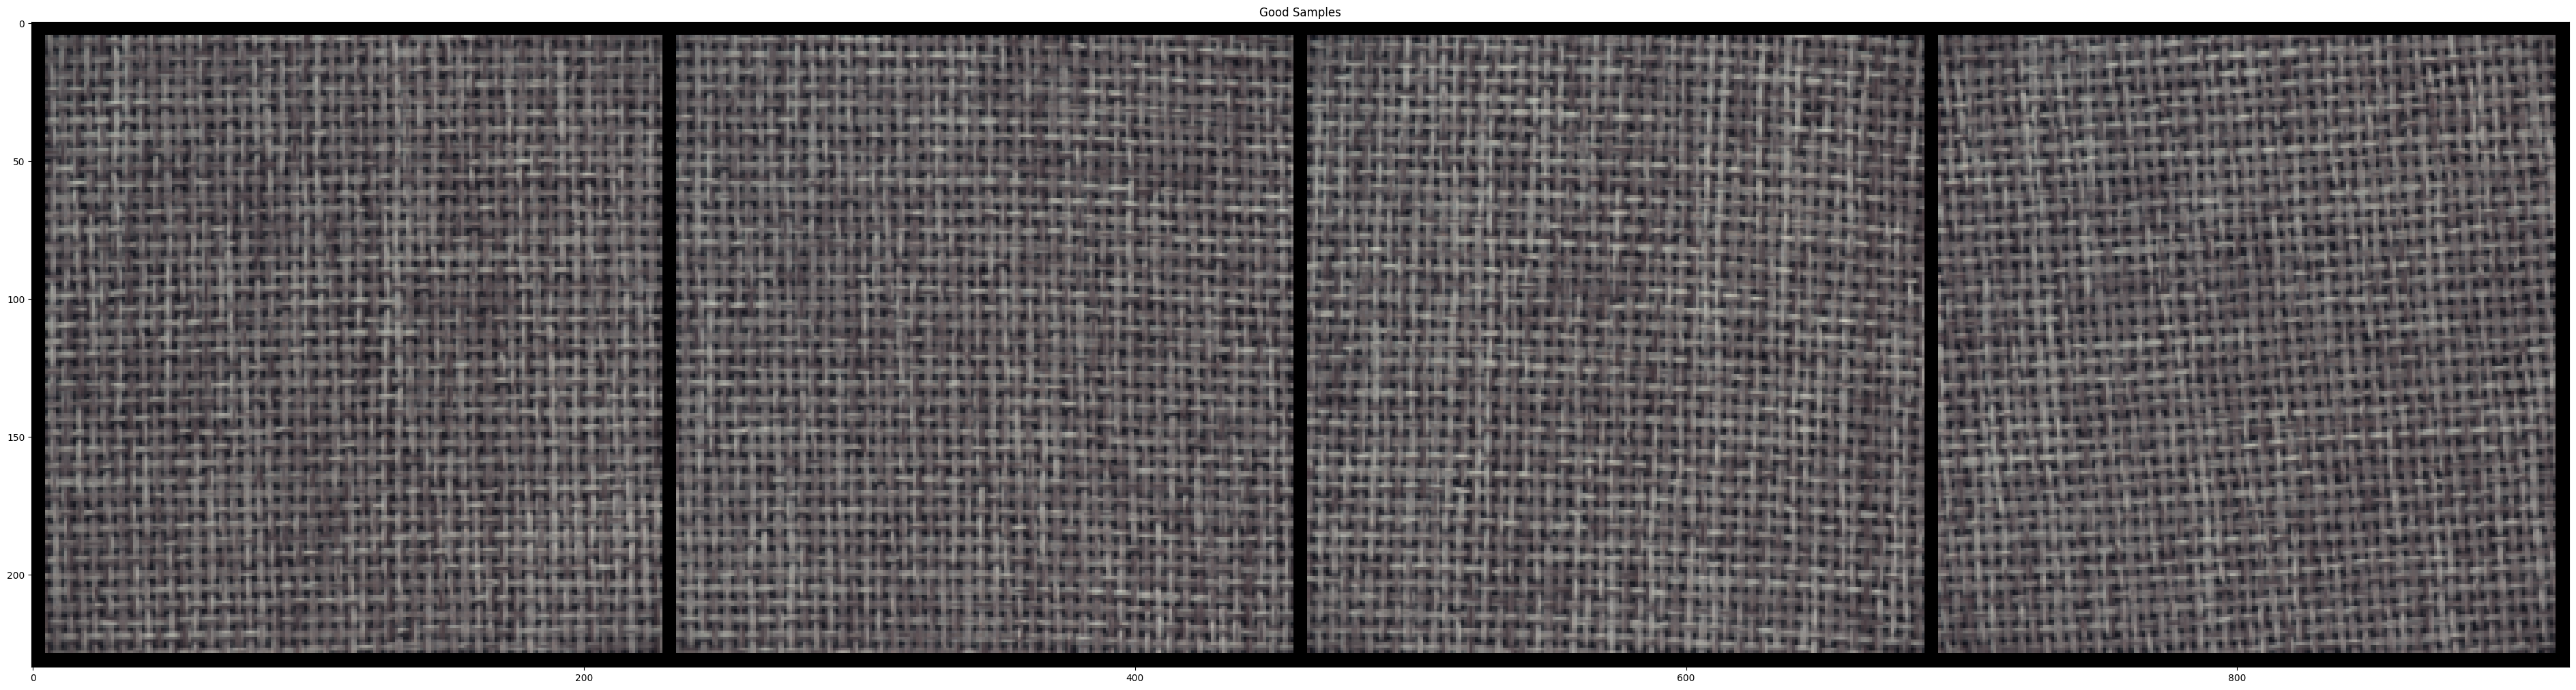

In [8]:
import torchvision

plt.figure(figsize=(12*4, 48*4))

# Create a grid of images from the image batch and visualize it
grid = torchvision.utils.make_grid(image_batch[0:4], padding=5, nrow=4)
plt.imshow(grid.permute(1, 2, 0)) # Permute dimensions (height, width, channels) for visualization
plt.title("Good Samples")
plt.show()

## Convolutional Autoencoder

### Train autoencoder model

In [9]:
import torch.nn.functional as F
from torch import nn

input_image = Image.open("carpet/train/good/000.png")
input_image = transform(input_image)
print(input_image.shape)

input_image = input_image.unsqueeze(0) # adds an extra dimension (representing batch size)
print(input_image.shape)

c1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4)
x = c1(input_image)
ap1 = nn.AvgPool2d(kernel_size=2, stride=2)
x = ap1(x)
print(x.shape)
c2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4)
ap2 = nn.AvgPool2d(kernel_size=2, stride=2)
x = ap2(c2(x))
print(x.shape)
c3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
ap3 = nn.AvgPool2d(kernel_size=2, stride=2)
x = ap3(c3(x))
print(x.shape)

print("Final Latent Space")

c4 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, output_padding=1)
x = c4(x)
print(x.shape)
c5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2, output_padding=1)
x = c5(x)
print(x.shape)
c6 = nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=5, stride=2, output_padding=1)
x = c6(x)
print(x.shape)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 128, 110, 110])
torch.Size([1, 256, 53, 53])
torch.Size([1, 256, 25, 25])
Final Latent Space
torch.Size([1, 256, 53, 53])
torch.Size([1, 128, 110, 110])
torch.Size([1, 3, 224, 224])


In [10]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Test the autoencoder architecture
model = Autoencoder()
input_image = torch.randn(1, 3, 224, 224)
output_image = model(input_image)
print(output_image.shape)

torch.Size([1, 3, 224, 224])


In [11]:
# Define the loss function and optimizer

model.cuda() # Move the model to the GPU
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Trainig Loop

In [12]:
from tqdm import tqdm

In [13]:
# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []

num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train() # Set model to training mode
    for img, _ in train_loader:
        img = img.cuda()

        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad() # Clears the gradients of all optimized tensors
        loss.backward() # Computes the gradients of the loss function with respect to the model parameters
        optimizer.step() # Updates the model parameters using the computed gradients
    Loss.append(loss.item())

    # Calculate validation loss
    model.eval() # Set model to evaluation model
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for img, _ in test_loader:
            img = img.cuda()
            output = model(img)
            val_loss = criterion(output, img)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)
    
    if epoch % 5 == 0:
        print("Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}".format(epoch+1, num_epochs, loss.item(), val_loss_avg))

plt.plot(Loss, label="Training Loss")
plt.plot(Validation_Loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

  0%|          | 0/100 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [14]:
# Save the model
# torch.save(model.state_dict(), "simple_autoencoder_l2_loss.pth")
# model.eval()

ckpoints = torch.load("simple_autoencoder_l2_loss.pth")
model.load_state_dict(ckpoints)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_30852\2307060762.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpoints = torch.load("simple_autoencoder_l2_loss.pth")


<All keys matched successfully>

## Reconstruction of images

### Reconstruction of good images

torch.Size([16, 224, 224])


<Figure size 1600x1200 with 0 Axes>

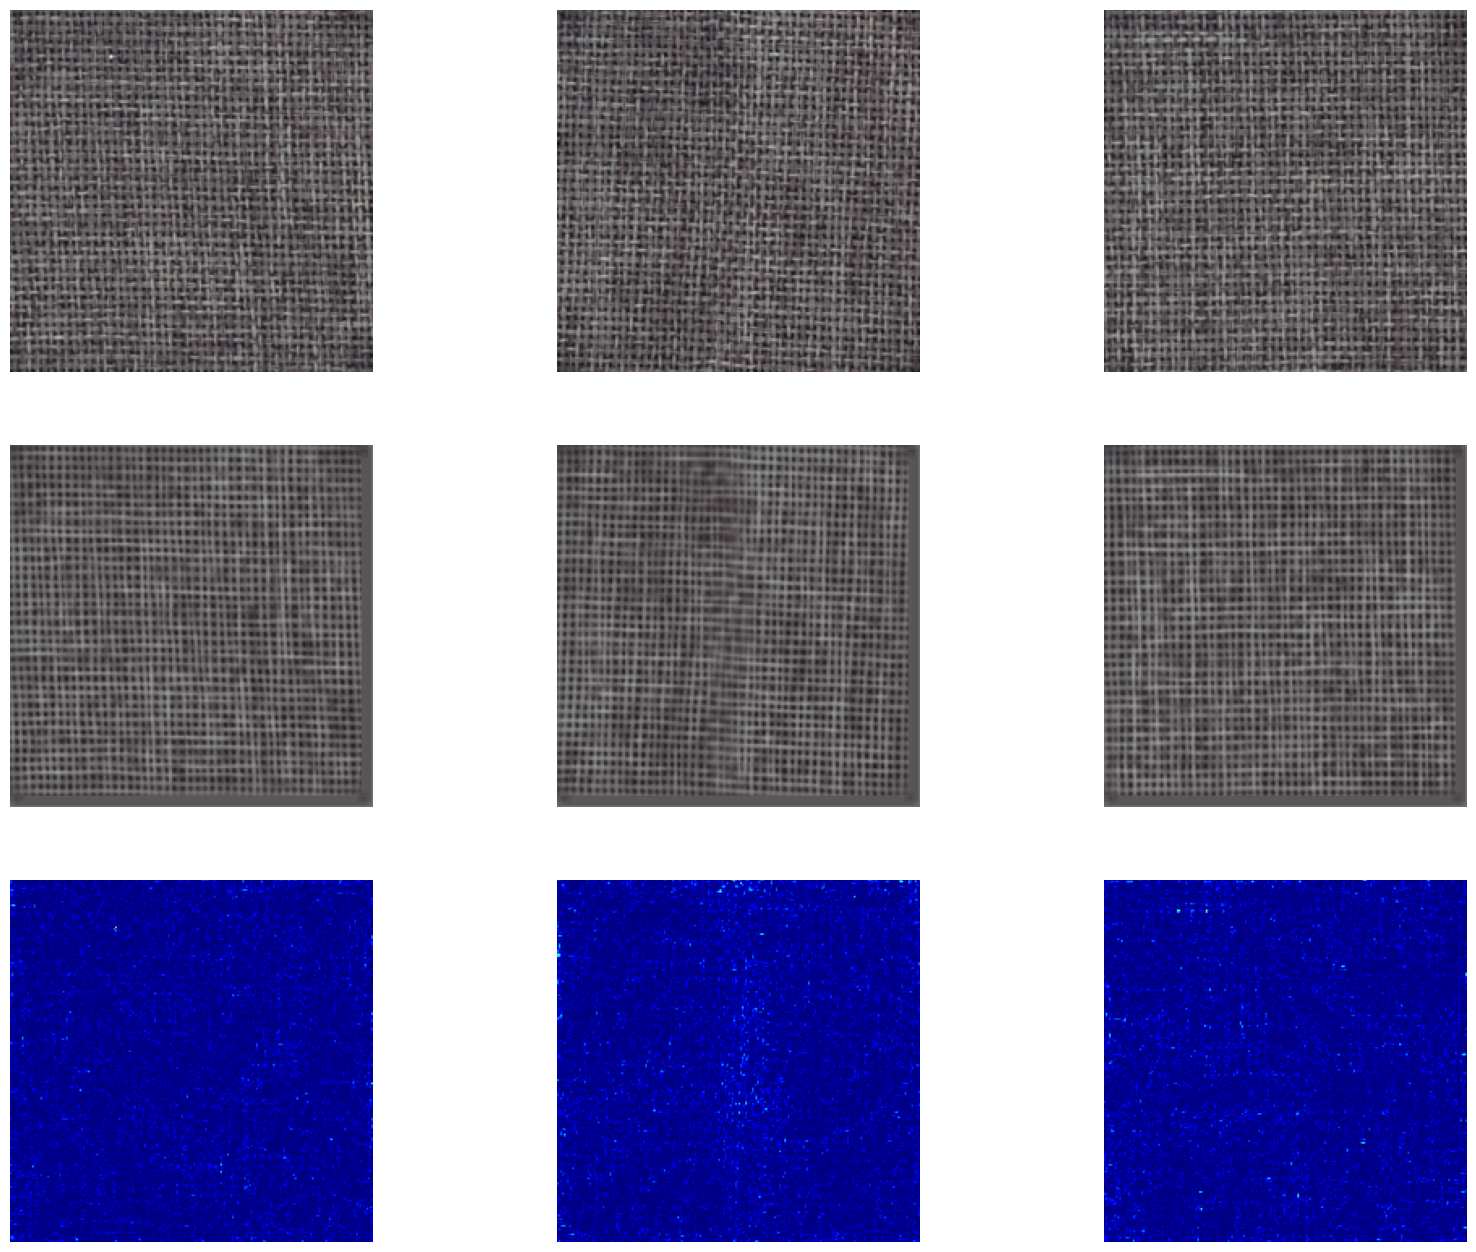

In [15]:
with torch.no_grad():
    for data, _ in train_loader:
        data = data.cuda()
        recon = model(data)
        break

recon_error = ((data-recon)**2).mean(axis=1)
print(recon_error.shape)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10, 0:-10].cpu().numpy(), cmap="jet", vmax=torch.max(recon_error[i]))
    ax[0, i].axis("OFF")
    ax[1, i].axis("OFF")
    ax[2, i].axis("OFF")
plt.show()

### Reconstruction of bad images

#### Obtain the fault detection HEATMAP using AE

<Figure size 1600x1200 with 0 Axes>

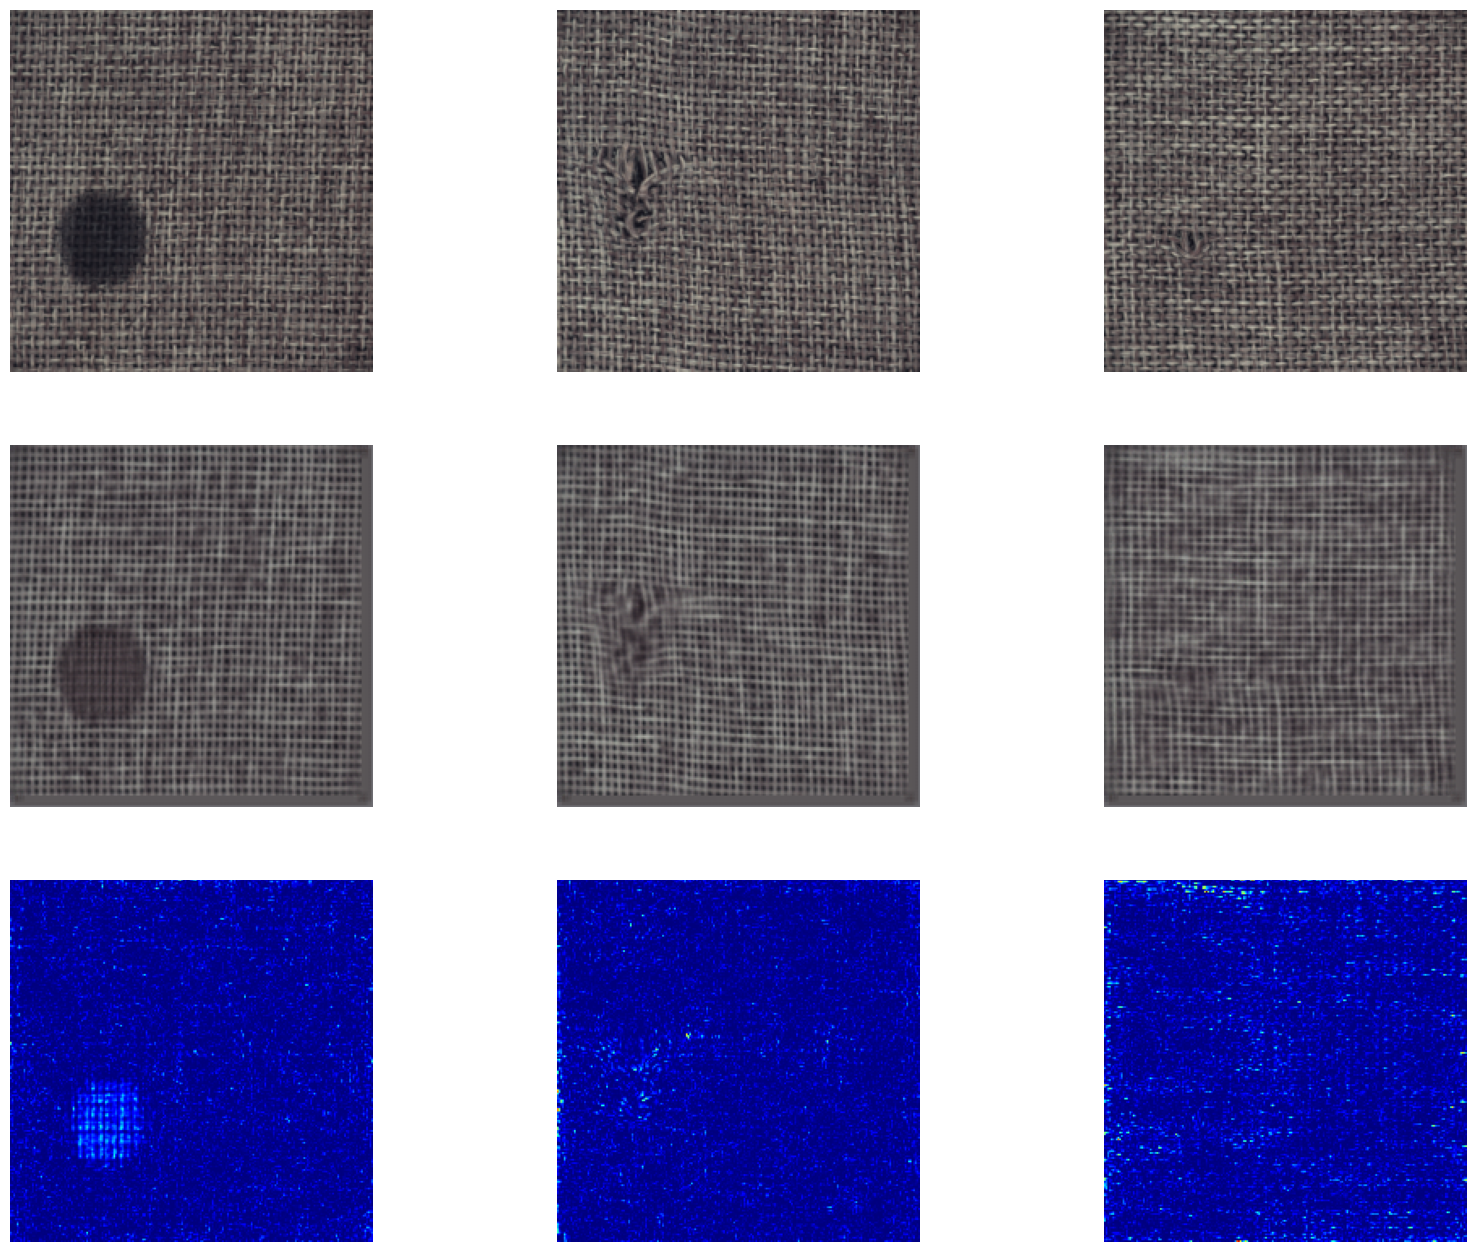

In [16]:
test_image_1 = transform(Image.open("carpet/test/color/000.png"))
test_image_2 = transform(Image.open("carpet/test/cut/000.png"))
test_image_3 = transform(Image.open("carpet/test/hole/000.png"))

data = torch.stack([test_image_1, test_image_2, test_image_3])

with torch.no_grad():
    data = data.cuda()
    recon = model(data)

recon_error = ((data-recon)**2).mean(axis=1)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10, 0:-10].cpu().numpy(), cmap="jet", vmax=torch.max(recon_error[i]))
    ax[0, i].axis("OFF")
    ax[1, i].axis("OFF")
    ax[2, i].axis("OFF")
plt.show()

### Obtain the fault detection accuracy

In [17]:
RECON_ERROR = []
with torch.no_grad():
    for data, _ in train_loader:
        data = data.cuda()
        recon = model(data)
        data_recon_squared_mean = ((data-recon)**2).mean(axis=(1))[:, 0:-10, 0:-10].mean(axis=(1, 2))

        RECON_ERROR.append(data_recon_squared_mean)
    
RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()

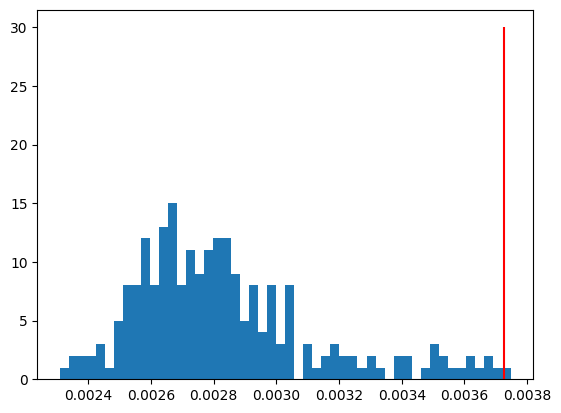

In [18]:
import numpy as np

best_threshold = np.mean(RECON_ERROR) + 3 * np.std(RECON_ERROR)

plt.hist(RECON_ERROR, bins=50)
plt.vlines(x=best_threshold, ymin=0, ymax=30, colors='r')
plt.show()

In [20]:
from pathlib import Path

In [21]:
y_true = []
y_pred = []
y_score = []

model.eval()

with torch.no_grad():

    test_path = Path("carpet/test")

    for path in test_path.glob("*/*.png"):
        fault_type = path.parts[-2]
        
        # if fault_type != "good":
        test_image = transform(Image.open(path)).cuda().unsqueeze(0)
        recon_images = model(test_image)

        y_score_image = ((test_image - recon_images)**2).mean(axis=(1))[:, 0:-10, 0:-10].mean()

        y_pred_image = 1 * (y_score_image >= best_threshold)

        y_true_image = 0 if fault_type == "good" else 1

        y_true.append(y_true_image)
        y_pred.append(y_pred_image.cpu())
        y_score.append(y_score_image.cpu())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

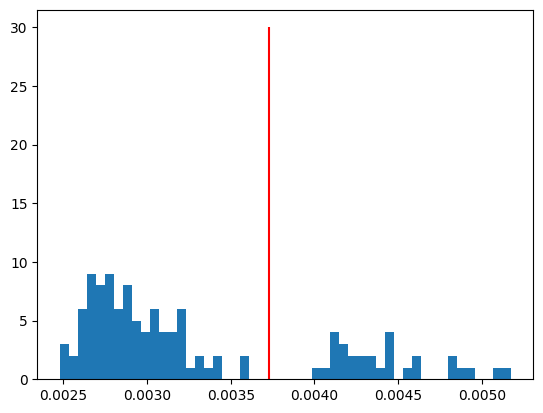

In [22]:
plt.hist(y_score, bins=50)
plt.vlines(x=best_threshold, ymin=0, ymax=30, colors='r')
plt.show()

AUC-ROC Score: 0.4382022471910112


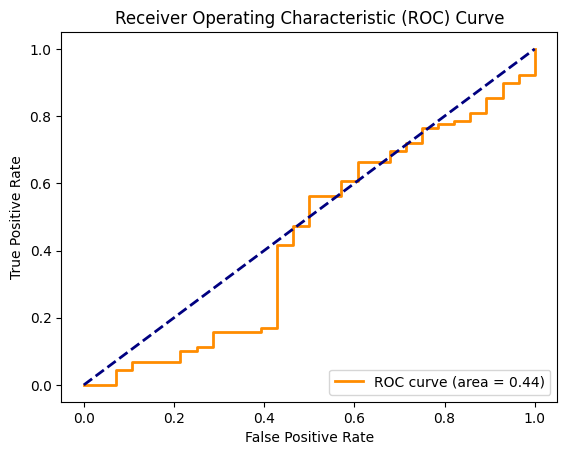

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns

# Calculate AUC-ROC curve
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, threshold = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % auc_roc_score)
plt.plot([0, 1], [0, 1], color = "navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()